In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_video
from torch import nn
import json
from os import path
from typing import Self, TypedDict, Union, Optional, Literal, List, Tuple
import time
import glob

DATA_PATH = 'D:\dfdc'
NUM_PARTS = 50
Split = Union[Literal['train'], Literal['validation']]
Label = Union[Literal[0], Literal[1]]

In [26]:

class FileMetadata(TypedDict):
  path: str
  label: Union[Literal['REAL'], Literal['FAKE']]
  original: Optional[str]

class VideoDataset(Dataset):
  def __init__(self: Self, root_path: str, split: Split):
    self.root_path = root_path

    # Init metadata
    self.metadata: List[FileMetadata] = []
    metadata_glob = glob.iglob('**/metadata.json', root_dir=root_path)
    metadata_paths = [path.join(root_path, p) for p in metadata_glob]
    for metadata_path in metadata_paths:
      print(f'reading metadata from {metadata_path}...')
      start = time.time()
      metadata = json.load(open(metadata_path))
      post_load = time.time()
      print(f'loading json took {1_000*(post_load - start):.2f}ms')
      for k, data in metadata.items():
        if data['split'] != split:
          continue

        video_path = path.join(path.dirname(metadata_path), k)
        data['path'] = video_path
        del data['split']

        self.metadata.append(data)
      
      post_parse = time.time()
      print(f'parsing json took {1_000*(post_parse - post_load):.2f}ms')


  def __getitem__(self: Self, index: int) -> Tuple[torch.Tensor, Label]:
    metadata = self.metadata[index]
    # How do we handle the audio as well?
    video, audio, _ = read_video(metadata['path'], pts_unit='sec')
    label = 1 if metadata['label'] == 'FAKE' else 0


    return video, label
  
  def __len__(self: Self):
    return len(self.metadata)

In [27]:
# Test the VideoDataset
loader = DataLoader(VideoDataset(DATA_PATH, 'train'))

reading metadata from D:\dfdc\dfdc_train_part_0\metadata.json...
loading json took 2.00ms
parsing json took 5.00ms
reading metadata from D:\dfdc\dfdc_train_part_1\metadata.json...
loading json took 2.04ms
parsing json took 7.48ms
reading metadata from D:\dfdc\dfdc_train_part_10\metadata.json...
loading json took 3.00ms
parsing json took 12.21ms
reading metadata from D:\dfdc\dfdc_train_part_11\metadata.json...
loading json took 2.40ms
parsing json took 8.00ms
reading metadata from D:\dfdc\dfdc_train_part_12\metadata.json...
loading json took 2.00ms
parsing json took 16.47ms
reading metadata from D:\dfdc\dfdc_train_part_13\metadata.json...
loading json took 6.00ms
parsing json took 16.12ms
reading metadata from D:\dfdc\dfdc_train_part_14\metadata.json...
loading json took 3.02ms
parsing json took 9.79ms
reading metadata from D:\dfdc\dfdc_train_part_15\metadata.json...
loading json took 2.03ms
parsing json took 9.01ms
reading metadata from D:\dfdc\dfdc_train_part_16\metadata.json...
loadi

tensor([1])


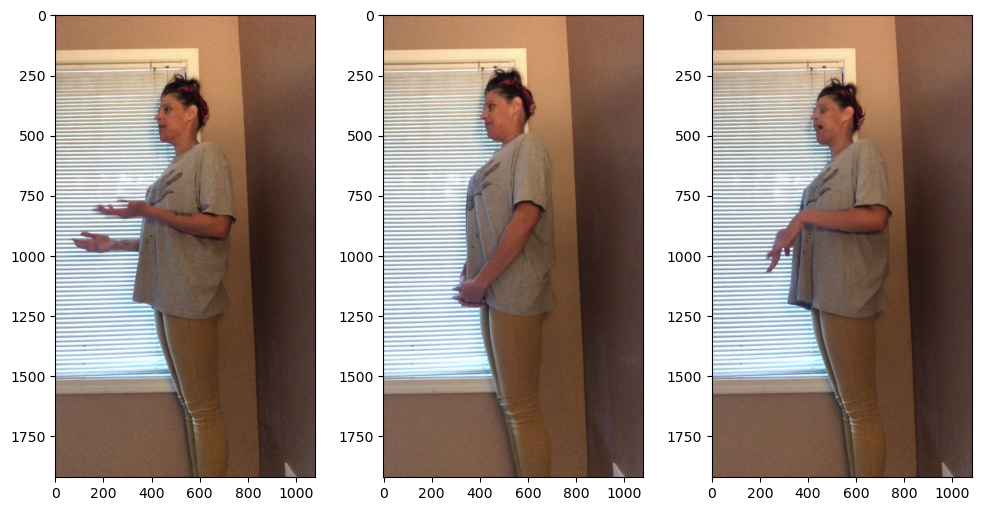

In [11]:
from matplotlib import pyplot as plt

# Get some images & labels from the data loader

data, label = next(iter(loader))

# data dimensions are BxTxCxHxW

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 3, 1)
plt.imshow(data[0][0])
fig.add_subplot(1, 3, 2)
plt.imshow(data[0][100])
fig.add_subplot(1, 3, 3)
plt.imshow(data[0][-1])

print(label)


In [12]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [13]:
model = nn.Sequential(
    nn.Conv3d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

In [14]:
train_dl = DataLoader(VideoDataset(DATA_PATH, 'train'))
validation_dl = DataLoader(VideoDataset(DATA_PATH, 'validation'))

['D:\\dfdc\\dfdc_train_part_0\\metadata.json', 'D:\\dfdc\\dfdc_train_part_1\\metadata.json', 'D:\\dfdc\\dfdc_train_part_10\\metadata.json', 'D:\\dfdc\\dfdc_train_part_11\\metadata.json', 'D:\\dfdc\\dfdc_train_part_12\\metadata.json', 'D:\\dfdc\\dfdc_train_part_13\\metadata.json', 'D:\\dfdc\\dfdc_train_part_14\\metadata.json', 'D:\\dfdc\\dfdc_train_part_15\\metadata.json', 'D:\\dfdc\\dfdc_train_part_16\\metadata.json', 'D:\\dfdc\\dfdc_train_part_17\\metadata.json', 'D:\\dfdc\\dfdc_train_part_18\\metadata.json', 'D:\\dfdc\\dfdc_train_part_19\\metadata.json', 'D:\\dfdc\\dfdc_train_part_2\\metadata.json', 'D:\\dfdc\\dfdc_train_part_20\\metadata.json', 'D:\\dfdc\\dfdc_train_part_21\\metadata.json', 'D:\\dfdc\\dfdc_train_part_22\\metadata.json', 'D:\\dfdc\\dfdc_train_part_23\\metadata.json', 'D:\\dfdc\\dfdc_train_part_24\\metadata.json', 'D:\\dfdc\\dfdc_train_part_25\\metadata.json', 'D:\\dfdc\\dfdc_train_part_26\\metadata.json', 'D:\\dfdc\\dfdc_train_part_27\\metadata.json', 'D:\\dfdc\\dfdc

In [15]:
from train_model import TrainModel

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
score_fn = nn.Softmax(dim=1)
num_epochs = 10

train_model = TrainModel(model, train_dl, validation_dl, optimizer, num_epochs, loss_fn, score_fn)


RuntimeError: Input type (unsigned char) and bias type (float) should be the same